In [0]:
from google.colab import drive
import os
import sys

import pickle
import logging

import time
import math

import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

In [2]:
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# ---
# change path if needed
# ---
path_to_ptm = 'drive/My Drive/univ/master-2/data-science/6'
os.chdir(path_to_ptm)
sys.path.append(path_to_ptm)
os.environ['PYTHONPATH'] += ":" + path_to_ptm

# ---
# import topic models from https://github.com/arongdari/python-topic-model/
# credits to Dongwoo Kim
# ---
from ptm import AuthorTopicModel, GibbsLDA
from ptm.utils import convert_cnt_to_list, get_top_words
from tfidf_transform import tf_idf_transform

logger = logging.getLogger('AuthorTopicModel')
logger.propagate = False

%matplotlib inline

# Clustering

## Dataset CORA

Dataset originel disponible à : https://people.cs.umass.edu/~mccallum/data.html

In [0]:
PATH_to_Data_Cora="./"
doc_ids = pickle.load(open(PATH_to_Data_Cora + 'cora/doc_ids.pkl', 'rb'))
doc_cnt = pickle.load(open(PATH_to_Data_Cora + 'cora/doc_cnt.pkl', 'rb'))
doc_author = pickle.load(open(PATH_to_Data_Cora + 'cora/doc_authorid.pkl', 'rb'))
author_name = pickle.load(open(PATH_to_Data_Cora + 'cora/authorid_authorname.pkl', 'rb'))
voca = pickle.load(open(PATH_to_Data_Cora + 'cora/voca.pkl', 'rb'))

### Contenu des structures de données
- voca : 
C'est une liste des mots du vocabulaire de l'ensemble des documents. Les autres structures de données font référence aux indices des ots dans cette liste. 
- author_name : 
C'est une liste des auteurs de l'ensemble des documents. Les autres structures de données font référence aux indices des auteurs dans cette liste. 
- doc_author : 
C'est une liste de listes (une par document). La liste d'un document contient les indices des auteurs du document 
- doc_ids : 
C'est une liste de listes (une par document). La liste d'un document contient les indices des mots apparaissant dans le document 
- doc_cnt :
C'est une liste de listes (une par document). La liste d'un document contient le nombre de fois qu'apparait chaque mot du document tel que spédicifié dans la liste correspondante dans doc_ids 


In [5]:
print len(doc_ids)
print len(doc_cnt)
print len(doc_author)
print len(author_name)
print len(voca)
print len(doc_ids[1])
print doc_ids[1]
print doc_cnt[1]
print doc_author[1]
print voca[1]
print author_name[1]

13147
13147
13147
24486
17059
88
[13910, 4518, 10249, 16914, 4627, 15383, 15903, 8736, 10786, 14970, 551, 7720, 2613, 1033, 15419, 5692, 3645, 10816, 14913, 10819, 16452, 12872, 14412, 16982, 2135, 5307, 13414, 9845, 17014, 5753, 7290, 4226, 7815, 7826, 10388, 13978, 11419, 9887, 8870, 1710, 2226, 6329, 2235, 10432, 14542, 6362, 16091, 16092, 6778, 9467, 5379, 9990, 3335, 16137, 7441, 3352, 16666, 15132, 7453, 11553, 14630, 647, 2348, 15166, 15684, 8518, 14667, 11622, 3434, 1389, 16756, 13689, 2440, 13713, 12189, 9638, 13234, 6072, 7839, 15811, 7625, 13771, 2519, 4058, 10715, 4579, 4069, 7167]
[1, 1, 1, 1, 2, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 2, 1, 4, 1, 3, 1, 2, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 9, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 9, 1]
[1174, 18535, 9596]
homomorphism
R Bello


In [6]:
corpus = convert_cnt_to_list(doc_ids, doc_cnt)
n_doc = len(corpus)
n_author = len(author_name)
n_voca = len(voca)

print n_doc
print n_author
print n_voca

13147
24486
17059


La fonction convert_cnt_to_list crée une structure de type liste de listes (une par document). La  liste d'un document contient l'ensemble des mots (des indices de mots) du document, éventuellement avec répétitions. 

In [7]:
print corpus[1]
print np.sum(doc_cnt[1])

[13910, 4518, 10249, 16914, 4627, 4627, 15383, 15903, 8736, 10786, 14970, 14970, 14970, 14970, 14970, 14970, 14970, 551, 7720, 2613, 1033, 15419, 5692, 5692, 5692, 5692, 3645, 10816, 14913, 14913, 14913, 10819, 16452, 12872, 12872, 12872, 14412, 14412, 14412, 16982, 2135, 5307, 5307, 13414, 9845, 17014, 5753, 7290, 4226, 4226, 4226, 7815, 7826, 7826, 10388, 10388, 10388, 13978, 11419, 11419, 9887, 8870, 8870, 8870, 8870, 1710, 2226, 2226, 2226, 6329, 2235, 2235, 10432, 14542, 6362, 6362, 6362, 16091, 16092, 6778, 6778, 9467, 9467, 5379, 9990, 3335, 16137, 7441, 3352, 16666, 15132, 7453, 11553, 14630, 14630, 647, 647, 2348, 2348, 15166, 15684, 15684, 15684, 8518, 14667, 14667, 14667, 14667, 14667, 14667, 14667, 14667, 14667, 11622, 3434, 1389, 16756, 13689, 2440, 13713, 12189, 12189, 12189, 9638, 13234, 6072, 7839, 15811, 7625, 13771, 2519, 2519, 2519, 4058, 10715, 10715, 4579, 4069, 4069, 4069, 4069, 4069, 4069, 4069, 4069, 4069, 7167]
147


### TF-IDF & normalisation

In [8]:
data_tf_idf = tf_idf_transform(corpus, doc_ids, n_doc, n_voca)
# ---
# standardization, mean removal and variance scaling
# ---
data_tf_idf_scaled = preprocessing.scale(data_tf_idf)

1.47375488281
2.153673172


## Clustering avec K-means et bag-of-words



En utilisant KMeans vous pouvez clusteriser les documents, en suposant qu'ils vont être rassemblés selon le facteur le plus important dans la similarité entre documents, le sujet dont ils parlent. 

Après apprentissage du KMeans vous pouvez identifier les termes les plus populaires dans les documents associés à un cluster et ainsi deviner de quel topic il s'agit.

# Rechercher le meilleur nombre de clusters pour le KMeans

In [9]:
"""
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
model_km = KMeans()

visualizer = KElbowVisualizer(
    model_km, k=(8, 12), metric='calinski_harabaz', timings=False
)
visualizer.fit(data_tf_idf)
visualizer.show()
"""

"\n# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html\nmodel_km = KMeans()\n\nvisualizer = KElbowVisualizer(\n    model_km, k=(8, 12), metric='calinski_harabaz', timings=False\n)\nvisualizer.fit(data_tf_idf)\nvisualizer.show()\n"

## Travail à faire

    1. Caractériser les solutions trouvées par les méthodes proposées (KMeans, LDA, Author-Topic model):
    - Définir une mesure de similarité entre topics. 
    - Calculer le degré de similarité minimmum, maximum et moyen entre deux topics en fonction du nombre d'itérations d'apprentissage de LDA et de AuthorTopic.
    - Tracer les courbes de ces statistiques des similarités pour plusieurs nombres de topics en fonction du nombre d'itérations. 
    2. Faire une figure situant les différents modèles testés en termes de vraisemblance des données (abscisse) et similarité moyenne (ordonnée).
    3. Il est possible d'utiliser les modèles AuthorTopic appris pour déterminer pour un document donné quels mots ont été écrits par quel auteur. Ecrivez le code correspondant en vous inspirant des codes de LDA et AuthorTopic pour calculer les probabilités nécessaires. 

# Q1 & Q2. Apprentissage de modèles et affichage des performances

Apprenez plusieurs modèles avec KMeans en variant le nombre de clusters et éventuellement la nature de la représentation.

Voir fin du notebook pour le travail à faire.
 

In [0]:
n_topic = 10
max_iter = 50
n_top_words = 10

#### Modèle TF-IDF

In [11]:
model1 = KMeans(n_clusters=n_topic)
model1.fit(data_tf_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
for ti in range(n_topic):
    top_words = get_top_words(model1.cluster_centers_, voca, ti, n_words=n_top_words)
    print('Topic', ti ,': ', ','.join(top_words))

('Topic', 0, ': ', u'help,rangemax,agentoriented,changed,roadmaps,mint,bonus,clique,economy,ksat')
('Topic', 1, ': ', u'supervisory,lzw,ucberl,constraint,bruce,cfgs,profilebased,anaphoric,struc,multivalued')
('Topic', 2, ': ', u'experienced,backwards,idl,school,constraint,spacebased,sensorimotor,supervisory,congestion,specitc')
('Topic', 3, ': ', u'sliding,mixed,depending,posterior,ellipsoid,judicial,generalist,ithaca,hypergraph,programpointspecific')
('Topic', 4, ': ', u'squashing,triton,readonce,failurefree,provable,incorporating,dance,formfactors,hinder,thermal')
('Topic', 5, ': ', u'compatible,fulltext,identifier,neural,faultdetection,wagner,proportionalshare,picosecond,autocorrelation,pervasive')
('Topic', 6, ': ', u'penalize,tense,animat,gaas,dba,peano,migration,prospero,hiddenunit,prune')
('Topic', 7, ': ', u'commits,rectangular,jpeg,shape,swamping,japan,multiplying,payment,afsc,tcpips')
('Topic', 8, ': ', u'yao,appear,neumann,eraser,leg,singlethreaded,test,unchanged,extensibili

#### Modèle TF-IDF + données centrées réduites

In [13]:
model2 = KMeans(n_clusters=n_topic)
model2.fit(data_tf_idf_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
for ti in range(n_topic):
    top_words = get_top_words(model2.cluster_centers_, voca, ti, n_words=n_top_words)
    print('Topic', ti ,': ', ','.join(top_words))

('Topic', 0, ': ', u'volumetric,ibstree,undesirable,metaheuristic,correct,ptime,intersects,matroids,restricting,unsymmetric')
('Topic', 1, ': ', u'issue,indicates,pseudoinverse,edinburgh,theoremproving,selectable,reality,multidestination,axon,recovering')
('Topic', 2, ': ', u'following,positively,discretize,rescheduling,average,tmsc,projection,ibms,reserve,acme')
('Topic', 3, ': ', u'referencing,virtually,infinitestate,cellcentered,respecting,xbased,endoscopy,titanium,grammar,euclidean')
('Topic', 4, ': ', u'splib,quadtree,prefixfree,suggest,controversy,unfavorable,highquality,whole,smt,frequency')
('Topic', 5, ': ', u'planspace,risksensitive,uppsala,dga,weekly,unobservable,vitro,contributes,unanticipated,differentiated')
('Topic', 6, ': ', u'false,dcws,eager,externally,wideissue,speciflc,tenth,syntactical,cop,linkedstore')
('Topic', 7, ': ', u'ising,ond,zpl,autonomic,benefiting,laxity,currying,dissemination,geographic,broadway')
('Topic', 8, ': ', u'denial,forte,networkaware,stereo,jo

### Analyse des resultats

Pour identifer les topics appris (cad. les clusters): 
  - afficher les mots les plus fréquents et discriminants (maximums des descripteurs)
  - afficher la population de chaque cluster
  - calculer une matrice de similarité entre les différents clusters

#### Utile:

- Vous pouvez utilser une représentation bag-of-words à partir des descripteurs initiaux ou bien utiliser une représentation tf-idf
- Vous utiliserez sklearn.cluster.KMeans pour apprendre le modèle k-means
- Vous pouvez ou pas normaliser vos données (centrées réduites, norme L2 etc)

In [15]:
docs_per_topic_model1 = np.zeros(n_topic)

for idx_doc in range(len(model1.labels_)):
    docs_per_topic_model1[model1.labels_[idx_doc]] += 1

for idx_topic in range(n_topic):
    n_docs = int(docs_per_topic_model1[idx_topic])
    print('topic', idx_topic, 'has', n_docs, 'docs')

('topic', 0, 'has', 89, 'docs')
('topic', 1, 'has', 66, 'docs')
('topic', 2, 'has', 598, 'docs')
('topic', 3, 'has', 1, 'docs')
('topic', 4, 'has', 1, 'docs')
('topic', 5, 'has', 1, 'docs')
('topic', 6, 'has', 1, 'docs')
('topic', 7, 'has', 1, 'docs')
('topic', 8, 'has', 1, 'docs')
('topic', 9, 'has', 16300, 'docs')


In [16]:
docs_per_topic_model2 = np.zeros(n_topic)

for idx_doc in range(len(model2.labels_)):
    docs_per_topic_model2[model2.labels_[idx_doc]] += 1

for idx_topic in range(n_topic):
    n_docs = int(docs_per_topic_model2[idx_topic])
    print('topic', idx_topic, 'has', n_docs, 'docs')

('topic', 0, 'has', 1, 'docs')
('topic', 1, 'has', 1, 'docs')
('topic', 2, 'has', 1, 'docs')
('topic', 3, 'has', 133, 'docs')
('topic', 4, 'has', 1, 'docs')
('topic', 5, 'has', 16918, 'docs')
('topic', 6, 'has', 1, 'docs')
('topic', 7, 'has', 1, 'docs')
('topic', 8, 'has', 1, 'docs')
('topic', 9, 'has', 1, 'docs')


## Représentation en 2D des centroïds du KMeans

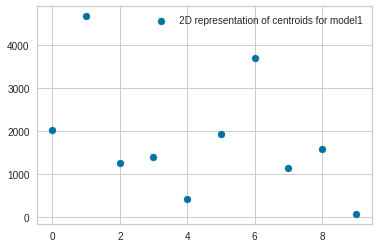

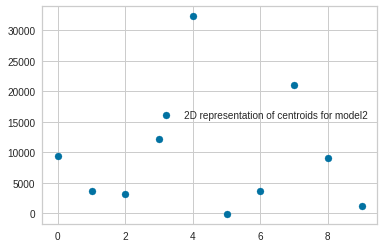

In [17]:
somme = np.sum(model1.cluster_centers_, axis=1)
plt.scatter(range(n_topic),
            somme, #s=docs_per_topic_model1,
            label='2D representation of centroids for model1')
plt.legend()
plt.show()

somme = np.sum(model2.cluster_centers_, axis=1)
plt.scatter(range(n_topic),
            somme, #s=docs_per_topic_model2,
            label='2D representation of centroids for model2')
plt.legend()
plt.show()

# **Conclusions KMeans**

* aucun résultat intéressant : les clusters sont complètement déséquilibrés

* l'affichage en 2D montre la 

## LDA

Vous pouvez utiliser le package *ptm* qui implémente de nombreux modèles à variables latentes, en utilisant le code des cellules suivantes. 

In [18]:
modelLDA = GibbsLDA(n_doc, len(voca), n_topic)
modelLDA.fit(corpus, max_iter=max_iter)

2019-11-17 13:44:41 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.76,	log_likelihood:-10865727.94
2019-11-17 13:44:53 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.74,	log_likelihood:-10531310.62
2019-11-17 13:45:05 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.71,	log_likelihood:-10282580.23
2019-11-17 13:45:17 INFO:GibbsLDA:[ITER] 3,	elapsed time:11.66,	log_likelihood:-10094103.79
2019-11-17 13:45:29 INFO:GibbsLDA:[ITER] 4,	elapsed time:11.80,	log_likelihood:-9942644.17
2019-11-17 13:45:41 INFO:GibbsLDA:[ITER] 5,	elapsed time:11.72,	log_likelihood:-9814131.60
2019-11-17 13:45:52 INFO:GibbsLDA:[ITER] 6,	elapsed time:11.73,	log_likelihood:-9696594.08
2019-11-17 13:46:04 INFO:GibbsLDA:[ITER] 7,	elapsed time:11.75,	log_likelihood:-9588532.08
2019-11-17 13:46:16 INFO:GibbsLDA:[ITER] 8,	elapsed time:11.59,	log_likelihood:-9489646.04
2019-11-17 13:46:28 INFO:GibbsLDA:[ITER] 9,	elapsed time:11.75,	log_likelihood:-9406976.17
2019-11-17 13:46:40 INFO:GibbsLDA:[ITER] 10,	elapsed time:11.66,	log_likelihood:-93322

### Analyse des résultats

Identifiez les 10 mots les plus probables pour chaque topic appris.

In [19]:
for ti in range(n_topic):
    top_words = get_top_words(modelLDA.TW, voca, ti, n_words=n_top_words)
    print('Topic', ti ,': ', ','.join(top_words))

('Topic', 0, ': ', u'system,information,data,language,object,database,user,model,query,tool')
('Topic', 1, ': ', u'program,language,constraint,problem,logic,system,type,analysis,paper,programming')
('Topic', 2, ': ', u'research,science,part,computer,grant,supported,report,work,university,paper')
('Topic', 3, ': ', u'system,design,protocol,process,software,model,paper,message,security,present')
('Topic', 4, ': ', u'algorithm,data,problem,query,method,tree,search,result,set,learning')
('Topic', 5, ': ', u'network,performance,algorithm,traffic,routing,protocol,time,packet,control,simulation')
('Topic', 6, ': ', u'parallel,performance,memory,program,data,processor,application,code,system,machine')
('Topic', 7, ': ', u'algorithm,problem,method,time,function,image,model,bound,result,graph')
('Topic', 8, ': ', u'system,application,distributed,service,support,server,resource,paper,user,network')
('Topic', 9, ': ', u'learning,agent,system,model,network,task,problem,knowledge,approach,paper')


##  Modèle author-topic

* "The Author-Topic Model for Authors and Documents" by Rosen-Zvi, et al. (UAI 2004)

In [20]:
modelAT = AuthorTopicModel(n_doc, n_voca, n_topic, n_author)
modelAT.fit(corpus, doc_author, max_iter=max_iter)

2019-11-17 13:55:16 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.10	log_likelihood:-10863423.25
2019-11-17 13:55:46 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.24	log_likelihood:-10650591.08
2019-11-17 13:56:16 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.46	log_likelihood:-10493923.28
2019-11-17 13:56:47 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.60	log_likelihood:-10355770.03
2019-11-17 13:57:17 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:30.37	log_likelihood:-10222276.16
2019-11-17 13:57:48 INFO:AuthorTopicModel:[INIT] 5	elapsed_time:30.36	log_likelihood:-10078288.14
2019-11-17 13:58:18 INFO:AuthorTopicModel:[INIT] 6	elapsed_time:30.41	log_likelihood:-9917225.69
2019-11-17 13:58:49 INFO:AuthorTopicModel:[INIT] 7	elapsed_time:30.49	log_likelihood:-9751661.91
2019-11-17 13:59:19 INFO:AuthorTopicModel:[INIT] 8	elapsed_time:30.33	log_likelihood:-9599492.51
2019-11-17 13:59:49 INFO:AuthorTopicModel:[INIT] 9	elapsed_time:30.11	log_likelihood:-9473467.34
2019-11-17 14:00:20 INFO

### Analyse: Les 10 mots les plus probables pour chaque topic

In [21]:
for k in range(n_topic):
    top_words = get_top_words(modelAT.TW, voca, k, n_words=n_top_words)
    print('topic ', k , ','.join(top_words))

('topic ', 0, u'method,problem,algorithm,matrix,function,linear,model,constraint,paper,system')
('topic ', 1, u'parallel,performance,memory,data,application,system,processor,communication,algorithm,implementation')
('topic ', 2, u'program,analysis,code,language,programming,compiler,technique,paper,optimization,execution')
('topic ', 3, u'network,protocol,service,application,performance,server,system,communication,paper,file')
('topic ', 4, u'research,part,science,model,grant,proof,logic,supported,formal,specification')
('topic ', 5, u'data,query,database,language,information,rule,object,constraint,system,view')
('topic ', 6, u'algorithm,problem,time,result,show,bound,graph,function,tree,number')
('topic ', 7, u'model,network,image,learning,using,method,algorithm,data,neural,feature')
('topic ', 8, u'learning,agent,problem,knowledge,planning,paper,approach,domain,task,information')
('topic ', 9, u'system,design,environment,application,software,model,distributed,user,paper,architecture')

### Afficher la distribution sur les topics pour quelques auteurs particuliers

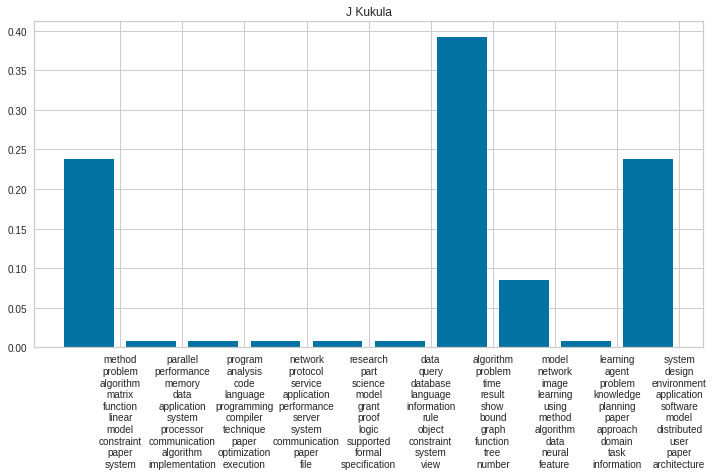

In [22]:
author_id = 7
fig = plt.figure(figsize=(12,6))
plt.bar(range(n_topic), modelAT.AT[author_id]/np.sum(modelAT.AT[author_id]))
plt.title(author_name[author_id])
plt.xticks(np.arange(n_topic)+0.5, ['\n'.join(get_top_words(modelAT.TW, voca, k, n_top_words)) for k in range(n_topic)])
plt.show()
modelAT

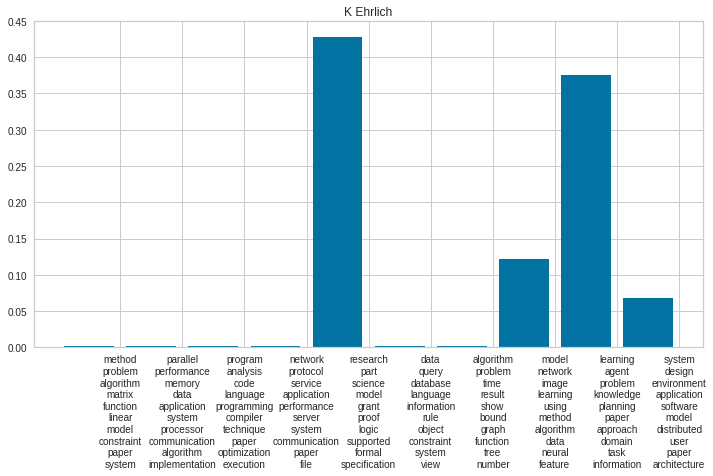

In [23]:
author_id = 32
fig = plt.figure(figsize=(12,6))
plt.bar(range(n_topic), modelAT.AT[author_id]/np.sum(modelAT.AT[author_id]))
plt.title(author_name[author_id])
plt.xticks(np.arange(n_topic)+0.5, ['\n'.join(get_top_words(modelAT.TW, voca, k, n_top_words)) for k in range(n_topic)])
plt.show()

## Mesure de similarité entre topics

### adjusted rand index
https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index

In [24]:
for k in range(n_topic):
    score = adjusted_rand_score(model1.cluster_centers_[k][:n_top_words],
                                model2.cluster_centers_[k][:n_top_words])
    print 'score between kmeans model 1 and 2 for topic', k, 'is :', score

for k in range(n_topic):
    adjusted_rand_score(modelAT.TW[k][:n_top_words],
                        modelLDA.TW[k][:n_top_words])
    print 'score between ATM and LDA for topic', k, 'is :', score

score between kmeans model 1 and 2 for topic 0 is : 1.0
score between kmeans model 1 and 2 for topic 1 is : 1.0
score between kmeans model 1 and 2 for topic 2 is : 1.0
score between kmeans model 1 and 2 for topic 3 is : 0.0
score between kmeans model 1 and 2 for topic 4 is : 0.0
score between kmeans model 1 and 2 for topic 5 is : 0.0
score between kmeans model 1 and 2 for topic 6 is : 0.0
score between kmeans model 1 and 2 for topic 7 is : 0.0
score between kmeans model 1 and 2 for topic 8 is : 0.0
score between kmeans model 1 and 2 for topic 9 is : 1.0
score between ATM and LDA for topic 0 is : 1.0
score between ATM and LDA for topic 1 is : 1.0
score between ATM and LDA for topic 2 is : 1.0
score between ATM and LDA for topic 3 is : 1.0
score between ATM and LDA for topic 4 is : 1.0
score between ATM and LDA for topic 5 is : 1.0
score between ATM and LDA for topic 6 is : 1.0
score between ATM and LDA for topic 7 is : 1.0
score between ATM and LDA for topic 8 is : 1.0
score between ATM

* **Conclusion** : ne convient pas

### Cosine similarity
https://en.wikipedia.org/wiki/https://en.wikipedia.org/wiki/Cosine_similarity

In [27]:
n_topic = 10
n_iter = range(1, 10)

results_LDA = {
    'mean': [],
    'min': [],
    'max': []
}
results_AT = {
    'mean': [],
    'min': [],
    'max': []
}

for iter_idx in n_iter:
    #LDA
    modelLDA = GibbsLDA(n_doc, len(voca), n_topic)
    modelLDA.fit(corpus, max_iter=iter_idx)
    print('fit LDA model with n_iter=', iter_idx)
    cos_lda = cosine_similarity(modelLDA.TW, Y=None, dense_output=True)
    results_LDA['mean'].append(np.mean(cos_lda))
    results_LDA['min'].append(np.min(cos_lda))
    results_LDA['max'].append(np.max(cos_lda))

    #AT
    modelAT = AuthorTopicModel(n_doc, n_voca, n_topic, n_author)
    modelAT.fit(corpus, doc_author, max_iter=iter_idx)
    print('fit AT model with n_iter=', iter_idx)
    cos_at = cosine_similarity(modelAT.TW, Y=None, dense_output=True)
    results_AT['mean'].append(np.mean(cos_at))
    results_AT['min'].append(np.min(cos_at))
    results_AT['max'].append(np.max(cos_at))

2019-11-17 15:38:07 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.90,	log_likelihood:-10866602.86


('fit LDA model with n_iter=', 1)


2019-11-17 15:38:58 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.51	log_likelihood:-10862678.78


('fit AT model with n_iter=', 1)


2019-11-17 15:39:13 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.06,	log_likelihood:-10866853.00
2019-11-17 15:39:25 INFO:GibbsLDA:[ITER] 1,	elapsed time:12.20,	log_likelihood:-10531785.34


('fit LDA model with n_iter=', 2)


2019-11-17 15:40:16 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.14	log_likelihood:-10863978.41
2019-11-17 15:40:46 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.35	log_likelihood:-10646619.18


('fit AT model with n_iter=', 2)


2019-11-17 15:41:00 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.73,	log_likelihood:-10864840.03
2019-11-17 15:41:12 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.93,	log_likelihood:-10530770.05
2019-11-17 15:41:24 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.75,	log_likelihood:-10285499.33


('fit LDA model with n_iter=', 3)


2019-11-17 15:42:16 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.75	log_likelihood:-10864101.45
2019-11-17 15:42:47 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.37	log_likelihood:-10648618.39
2019-11-17 15:43:17 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.53	log_likelihood:-10492020.38


('fit AT model with n_iter=', 3)


2019-11-17 15:43:31 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.78,	log_likelihood:-10866140.17
2019-11-17 15:43:43 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.94,	log_likelihood:-10530495.90
2019-11-17 15:43:55 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.86,	log_likelihood:-10280456.17
2019-11-17 15:44:07 INFO:GibbsLDA:[ITER] 3,	elapsed time:11.92,	log_likelihood:-10087238.39


('fit LDA model with n_iter=', 4)


2019-11-17 15:44:59 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.33	log_likelihood:-10863827.27
2019-11-17 15:45:29 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.28	log_likelihood:-10648223.99
2019-11-17 15:45:59 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.43	log_likelihood:-10490389.16
2019-11-17 15:46:30 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.28	log_likelihood:-10351202.01


('fit AT model with n_iter=', 4)


2019-11-17 15:46:44 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.89,	log_likelihood:-10867764.71
2019-11-17 15:46:56 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.89,	log_likelihood:-10530035.79
2019-11-17 15:47:08 INFO:GibbsLDA:[ITER] 2,	elapsed time:12.03,	log_likelihood:-10284341.21
2019-11-17 15:47:20 INFO:GibbsLDA:[ITER] 3,	elapsed time:12.09,	log_likelihood:-10093847.62
2019-11-17 15:47:32 INFO:GibbsLDA:[ITER] 4,	elapsed time:11.84,	log_likelihood:-9938915.51


('fit LDA model with n_iter=', 5)


2019-11-17 15:48:23 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.31	log_likelihood:-10864960.66
2019-11-17 15:48:53 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.30	log_likelihood:-10646926.36
2019-11-17 15:49:24 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.44	log_likelihood:-10487962.83
2019-11-17 15:49:55 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.62	log_likelihood:-10352439.31
2019-11-17 15:50:25 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:30.40	log_likelihood:-10219771.50


('fit AT model with n_iter=', 5)


2019-11-17 15:50:39 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.93,	log_likelihood:-10867585.21
2019-11-17 15:50:51 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.88,	log_likelihood:-10531352.26
2019-11-17 15:51:03 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.96,	log_likelihood:-10281490.86
2019-11-17 15:51:15 INFO:GibbsLDA:[ITER] 3,	elapsed time:12.05,	log_likelihood:-10092074.77
2019-11-17 15:51:27 INFO:GibbsLDA:[ITER] 4,	elapsed time:12.14,	log_likelihood:-9937697.48
2019-11-17 15:51:40 INFO:GibbsLDA:[ITER] 5,	elapsed time:11.99,	log_likelihood:-9802902.90


('fit LDA model with n_iter=', 6)


2019-11-17 15:52:31 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.42	log_likelihood:-10865859.46
2019-11-17 15:53:01 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.24	log_likelihood:-10649800.92
2019-11-17 15:53:31 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.41	log_likelihood:-10488049.50
2019-11-17 15:54:02 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.51	log_likelihood:-10351955.88
2019-11-17 15:54:32 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:30.31	log_likelihood:-10215309.22
2019-11-17 15:55:03 INFO:AuthorTopicModel:[INIT] 5	elapsed_time:30.78	log_likelihood:-10069306.38


('fit AT model with n_iter=', 6)


2019-11-17 15:55:17 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.09,	log_likelihood:-10865704.71
2019-11-17 15:55:30 INFO:GibbsLDA:[ITER] 1,	elapsed time:12.15,	log_likelihood:-10530623.67
2019-11-17 15:55:42 INFO:GibbsLDA:[ITER] 2,	elapsed time:12.09,	log_likelihood:-10281698.50
2019-11-17 15:55:54 INFO:GibbsLDA:[ITER] 3,	elapsed time:12.06,	log_likelihood:-10089858.75
2019-11-17 15:56:06 INFO:GibbsLDA:[ITER] 4,	elapsed time:12.08,	log_likelihood:-9934732.16
2019-11-17 15:56:18 INFO:GibbsLDA:[ITER] 5,	elapsed time:12.13,	log_likelihood:-9798259.58
2019-11-17 15:56:31 INFO:GibbsLDA:[ITER] 6,	elapsed time:12.16,	log_likelihood:-9670145.38


('fit LDA model with n_iter=', 7)


2019-11-17 15:57:23 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.69	log_likelihood:-10863134.74
2019-11-17 15:57:53 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.30	log_likelihood:-10648964.42
2019-11-17 15:58:23 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.35	log_likelihood:-10492311.27
2019-11-17 15:58:54 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.26	log_likelihood:-10358613.47
2019-11-17 15:59:24 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:30.40	log_likelihood:-10227087.69
2019-11-17 15:59:54 INFO:AuthorTopicModel:[INIT] 5	elapsed_time:30.47	log_likelihood:-10087274.24
2019-11-17 16:00:25 INFO:AuthorTopicModel:[INIT] 6	elapsed_time:30.33	log_likelihood:-9929410.93


('fit AT model with n_iter=', 7)


2019-11-17 16:00:39 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.90,	log_likelihood:-10866309.53
2019-11-17 16:00:51 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.87,	log_likelihood:-10530053.41
2019-11-17 16:01:03 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.87,	log_likelihood:-10279418.95
2019-11-17 16:01:15 INFO:GibbsLDA:[ITER] 3,	elapsed time:11.99,	log_likelihood:-10087467.00
2019-11-17 16:01:27 INFO:GibbsLDA:[ITER] 4,	elapsed time:11.81,	log_likelihood:-9926942.04
2019-11-17 16:01:39 INFO:GibbsLDA:[ITER] 5,	elapsed time:11.86,	log_likelihood:-9783061.21
2019-11-17 16:01:51 INFO:GibbsLDA:[ITER] 6,	elapsed time:11.89,	log_likelihood:-9651388.47
2019-11-17 16:02:03 INFO:GibbsLDA:[ITER] 7,	elapsed time:11.94,	log_likelihood:-9528948.70


('fit LDA model with n_iter=', 8)


2019-11-17 16:02:54 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.26	log_likelihood:-10864627.23
2019-11-17 16:03:25 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.48	log_likelihood:-10646986.70
2019-11-17 16:03:55 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.32	log_likelihood:-10490714.40
2019-11-17 16:04:25 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.29	log_likelihood:-10356811.11
2019-11-17 16:04:55 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:30.25	log_likelihood:-10228127.32
2019-11-17 16:05:26 INFO:AuthorTopicModel:[INIT] 5	elapsed_time:30.30	log_likelihood:-10092890.89
2019-11-17 16:05:56 INFO:AuthorTopicModel:[INIT] 6	elapsed_time:30.50	log_likelihood:-9941141.31
2019-11-17 16:06:27 INFO:AuthorTopicModel:[INIT] 7	elapsed_time:30.37	log_likelihood:-9772309.89


('fit AT model with n_iter=', 8)


2019-11-17 16:06:41 INFO:GibbsLDA:[ITER] 0,	elapsed time:11.80,	log_likelihood:-10865585.39
2019-11-17 16:06:53 INFO:GibbsLDA:[ITER] 1,	elapsed time:11.81,	log_likelihood:-10533805.31
2019-11-17 16:07:04 INFO:GibbsLDA:[ITER] 2,	elapsed time:11.75,	log_likelihood:-10283915.32
2019-11-17 16:07:16 INFO:GibbsLDA:[ITER] 3,	elapsed time:11.88,	log_likelihood:-10096369.86
2019-11-17 16:07:28 INFO:GibbsLDA:[ITER] 4,	elapsed time:11.77,	log_likelihood:-9944606.28
2019-11-17 16:07:40 INFO:GibbsLDA:[ITER] 5,	elapsed time:11.90,	log_likelihood:-9817944.39
2019-11-17 16:07:52 INFO:GibbsLDA:[ITER] 6,	elapsed time:11.75,	log_likelihood:-9704204.67
2019-11-17 16:08:04 INFO:GibbsLDA:[ITER] 7,	elapsed time:11.65,	log_likelihood:-9602334.49
2019-11-17 16:08:16 INFO:GibbsLDA:[ITER] 8,	elapsed time:11.77,	log_likelihood:-9504717.80


('fit LDA model with n_iter=', 9)


2019-11-17 16:09:07 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.54	log_likelihood:-10864253.31
2019-11-17 16:09:38 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:30.47	log_likelihood:-10648687.57
2019-11-17 16:10:09 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:30.66	log_likelihood:-10491752.53
2019-11-17 16:10:39 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:30.34	log_likelihood:-10354922.50
2019-11-17 16:11:09 INFO:AuthorTopicModel:[INIT] 4	elapsed_time:30.15	log_likelihood:-10223870.30
2019-11-17 16:11:40 INFO:AuthorTopicModel:[INIT] 5	elapsed_time:30.49	log_likelihood:-10089269.71
2019-11-17 16:12:10 INFO:AuthorTopicModel:[INIT] 6	elapsed_time:30.41	log_likelihood:-9937884.28
2019-11-17 16:12:40 INFO:AuthorTopicModel:[INIT] 7	elapsed_time:30.20	log_likelihood:-9778476.43
2019-11-17 16:13:10 INFO:AuthorTopicModel:[INIT] 8	elapsed_time:30.12	log_likelihood:-9619138.77


('fit AT model with n_iter=', 9)


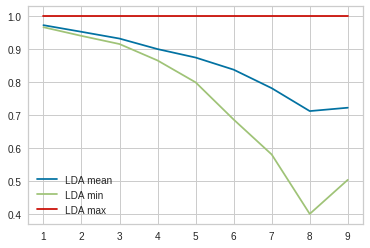

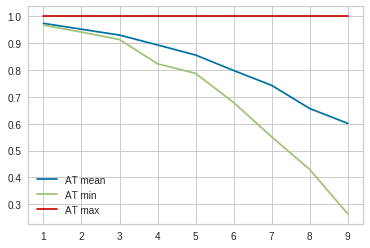

In [28]:
# LDA
plt.plot(n_iter, results_LDA['mean'], label='LDA mean')
plt.plot(n_iter, results_LDA['min'], label='LDA min')
plt.plot(n_iter, results_LDA['max'], label='LDA max')
plt.legend()
plt.show()

# AT
plt.plot(n_iter, results_AT['mean'], label='AT mean')
plt.plot(n_iter, results_AT['min'], label='AT min')
plt.plot(n_iter, results_AT['max'], label='AT max')
plt.legend()
plt.show()

* résultat logique au vu des affichages précédents puisque les 10 mots affichés pour les 10 topics sont presque identiques

* par contre on attendrait des résultats opposés : on aimerait que la cosinus similarité diminue, ce qui signifierait que nos topics sont de mieux en mieux distribués

# Q3. Quels mots ont été écrits par quels auteurs pour un document donné ?

---

* Bayes : P(A|W) = P(W|A) * P(A) / P(W)

* P(A) : le nombre de documents dans lequel a écrit un auteur sur le nombre total de docs

* P(W) : le nombre total de fois où apparaît le mot sur le nombre de total de mots

---

* La loi des probabilités totales nous donne aussi :
    * $\sum_i p(w|a_i) * p(t_i|a)$

In [0]:
def get_author_proba(idx_author, doc_authors):
    """
    returns P(A)
    """
    count = 0
    total = 0

    for idx_doc in range(len(doc_authors)):
        for _author_in_doc_idx in range(len(doc_authors[idx_doc])):
            if _author_in_doc_idx == idx_author:
                count += 1
        total += 1
    
    return count, total

def get_word_proba(idx_word, docs):
    """
    returns P(W)
    """
    count = 0
    total = 0

    for idx_doc in range(len(docs)):
        for _word_in_doc_idx in range(len(docs[idx_doc])):
            if docs[idx_doc][_word_in_doc_idx] == idx_word:
                count += 1
            total += 1
    
    return count, total

In [71]:
word_idx = 832
author_idx = 7

print(voca[word_idx], 'proba :', get_word_proba(word_idx, doc_ids))
print(author_name[author_idx], 'proba :', get_author_proba(author_idx, doc_author))

(u'desire', 'proba :', (28, 752892))
('J Kukula', 'proba :', (251, 13147))
